In [1]:
# Paper : "Generative Modeling by Estimating Gradients of the Data Distribution" by Yang Song et al. (2019)
# The code below was written with reference to the paper's official open source code.
# Github Repository : https://github.com/ermongroup/ncsn

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
import numpy as np
import tqdm
from PIL import Image
from functools import partial

In [3]:
config = {}

config['training'] = {}
config['training']['batch_size'] = 128
config['training']['n_epochs'] = 10
config['training']['anneal_power'] = 2.0

config['data'] = {}
config['data']['channels'] = 1
config['data']['image_size'] = 28
config['data']['logit_transform'] = False

config['model'] = {}
config['model']['sigma_begin'] = 1
config['model']['sigma_end'] = 0.01
config['model']['ngf'] = 64
config['model']['num_classes'] = 10

config['optim'] = {}
config['optim']['weight_decay'] = 0.000
config['optim']['lr'] = 0.001
config['optim']['beta1'] = 0.9
config['optim']['amsgrad'] = False

config['device'] = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
"""
3 Main Classes(Functions)
- "CondRefineNetDilated"
    >>> Scorenet that approximates to gradient of data distirbution.
    >>> Modified Refinenet.
    >>> More details are described below at the code.
- "anneal_dsm_score_estimation"
    >>> Calculate loss of score estimation using DSM.
- "anneal_Langevin_dynamics"
    >>> Generates images using annealed Langevin dynamics algorithm.
"""

'\n3 Main Classes(Functions)\n- "CondRefineNetDilated"\n    >>> Scorenet that approximates to gradient of data distirbution.\n    >>> Modified Refinenet.\n    >>> More details are described below at the code.\n- "anneal_dsm_score_estimation"\n    >>> Calculate loss of score estimation using DSM.\n- "anneal_Langevin_dynamics"\n    >>> Generates images using annealed Langevin dynamics algorithm.\n'

In [5]:
# All Functions and Classes in this kernel are used in final model "CondRefineNetDilated"

def conv3x3(in_planes, out_planes, stride=1, bias=False):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=bias)


def conv1x1(in_planes, out_planes, stride=1, bias=False):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                     padding=0, bias=bias)


def dilated_conv3x3(in_planes, out_planes, dilation, bias=True):
    # Dilated convolution is mainly used in Refinenet. It decreases size of the image data effectively.
    # Refer to Appendix A.2 of the paper for more detail.
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, padding=dilation, dilation=dilation, bias=bias)


class ConditionalInstanceNorm2d(nn.Module):
    """
    Normalize batch data according to the noise level.
    Noise level y generates gamma and beta to shift the normalized data.
    Refer to Appendix A.1 of the paper for more detail.

    Parameters:
        num_features (int) : Number of input channels
        num_classes (int) : Number of classes
        bias (bool) : Whether to add bias term
    """
    def __init__(self, num_features, num_classes, bias=True):
        super().__init__()
        self.num_features = num_features
        self.bias = bias
        self.instance_norm = nn.InstanceNorm2d(num_features, affine=False, track_running_stats=False)
        if bias:
            self.embed = nn.Embedding(num_classes, num_features * 2)
            self.embed.weight.data[:, :num_features].uniform_()  # Initialise scale at N(1, 0.02)
            self.embed.weight.data[:, num_features:].zero_()  # Initialise bias at 0
        else:
            self.embed = nn.Embedding(num_classes, num_features)
            self.embed.weight.data.uniform_()

    def forward(self, x, y):
        """
        Parameters:
            x (torch.Tensor) : Input data
            y (torch.Tensor) : Noise level

        Returns:
            torch.Tensor : Normalized data

        Example:
            >>> x = torch.randn(32,3,224,224)
            >>> y = torch.randint(0,10,(32,)) (if num_classes=10)
            >>> norm = ConditionalInstanceNorm2d(3,10)
            >>> h = norm(x,y)
            >>> print(h.shape) # torch.Size([32,3,224,224])
        """
        h = self.instance_norm(x)
        if self.bias:
            gamma, beta = self.embed(y).chunk(2, dim=-1)
            out = gamma.view(-1, self.num_features, 1, 1) * h + beta.view(-1, self.num_features, 1, 1)
        else:
            gamma = self.embed(y)
            out = gamma.view(-1, self.num_features, 1, 1) * h
        return out


class ConditionalBatchNorm2d(nn.Module):
    """
    Same structure with ConditionalInstanceNorm2d. InstanceNorm is replaced with BatchNorm.
    """
    def __init__(self, num_features, num_classes, bias=True):
        super().__init__()
        self.num_features = num_features
        self.bias = bias
        self.bn = nn.BatchNorm2d(num_features, affine=False)
        if self.bias:
            self.embed = nn.Embedding(num_classes, num_features * 2)
            self.embed.weight.data[:, :num_features].uniform_()  # Initialise scale at N(1, 0.02)
            self.embed.weight.data[:, num_features:].zero_()  # Initialise bias at 0
        else:
            self.embed = nn.Embedding(num_classes, num_features)
            self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.bn(x)
        if self.bias:
            gamma, beta = self.embed(y).chunk(2, dim=1)
            out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(-1, self.num_features, 1, 1)
        else:
            gamma = self.embed(y)
            out = gamma.view(-1, self.num_features, 1, 1) * out
        return out

"""
class CRPBlock(nn.Module):
    def __init__(self, features, n_stages, act=nn.ReLU()):
        super().__init__()
        self.convs = nn.ModuleList()
        for i in range(n_stages):
            self.convs.append(conv3x3(features, features, stride=1, bias=False))
        self.n_stages = n_stages
        self.maxpool = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)
        self.act = act

    def forward(self, x):
        x = self.act(x)
        path = x
        for i in range(self.n_stages):
            path = self.maxpool(path)
            path = self.convs[i](path)
            x = path + x
        return x
"""


class CondCRPBlock(nn.Module):
    """
    Conditioned Refinement Pooling Block.

    Parameters:
        features (int) : Input, output dimension
        n_stages (int) : Number of calculation steps
        num_classes (int) : Number of classes
        normalizer (nn.Module) : Normalizer
        act (nn.Module) : Activation function
    """
    def __init__(self, features, n_stages, num_classes, normalizer, act=nn.ReLU()):
        super().__init__()
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        for i in range(n_stages):
            self.norms.append(normalizer(features, num_classes, bias=True))
            self.convs.append(conv3x3(features, features, stride=1, bias=False))
        self.n_stages = n_stages
        self.maxpool = nn.AvgPool2d(kernel_size=5, stride=1, padding=2)
        self.act = act

    def forward(self, x, y):
        x = self.act(x)
        path = x
        for i in range(self.n_stages):
            path = self.norms[i](path, y)
            path = self.maxpool(path)
            path = self.convs[i](path)
            x = path + x
        return x


class CondRCUBlock(nn.Module):
    """
    Conditioned Residual Convolution Block.

    Parameters:
        features (int) : Input, output dimension
        n_blocks (int) : Number of blocks
        n_stages (int) : Number of calculation steps in each block
        num_classes (int) : Number of classes
        normalizer (nn.Module) : Normalizer
        act (nn.Module) : Activation function
    """
    def __init__(self, features, n_blocks, n_stages, num_classes, normalizer, act=nn.ReLU()):
        super().__init__()

        for i in range(n_blocks):
            for j in range(n_stages):
                setattr(self, '{}_{}_norm'.format(i + 1, j + 1), normalizer(features, num_classes, bias=True))
                setattr(self, '{}_{}_conv'.format(i + 1, j + 1),
                        conv3x3(features, features, stride=1, bias=False))

        self.stride = 1
        self.n_blocks = n_blocks
        self.n_stages = n_stages
        self.act = act

    def forward(self, x, y):
        for i in range(self.n_blocks):
            residual = x
            for j in range(self.n_stages):
                x = getattr(self, '{}_{}_norm'.format(i + 1, j + 1))(x, y)
                x = self.act(x)
                x = getattr(self, '{}_{}_conv'.format(i + 1, j + 1))(x)
            x += residual
        return x


class CondMSFBlock(nn.Module):
    """
    Conditioned Mutli-Scale Feature Block.

    Parameters:
        in_planes (list or tuple) : input channels
        features (int) : Output dimension
        num_classes (int) : Number of classes
        normalizer (nn.Module) : Normalizer
    """
    def __init__(self, in_planes, features, num_classes, normalizer):
        super().__init__()
        assert isinstance(in_planes, list) or isinstance(in_planes, tuple)

        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.features = features

        for i in range(len(in_planes)):
            self.convs.append(conv3x3(in_planes[i], features, stride=1, bias=True))
            self.norms.append(normalizer(in_planes[i], num_classes, bias=True))

    def forward(self, xs, y, shape):
        sums = torch.zeros(xs[0].shape[0], self.features, *shape, device=xs[0].device)
        for i in range(len(self.convs)):
            h = self.norms[i](xs[i], y)
            h = self.convs[i](h)
            h = F.interpolate(h, size=shape, mode='bilinear', align_corners=True)
            sums += h
        return sums


class CondRefineBlock(nn.Module):
    """
    This block is used repeatedly in final model "CondRefineNetDilated" to upsample the image data.

    Parameters:
        in_planes (int) : Input channels
        features (int) : Feature dimension
        num_classes (int) : Number of classes
        normalizer (nn.Module) : Normalizer
        act (nn.Module) : Activation function
        start, end (bool) : Whether it is the first or the last block
    """
    def __init__(self, in_planes, features, num_classes, normalizer, act=nn.ReLU(), start=False, end=False):
        super().__init__()

        assert isinstance(in_planes, tuple) or isinstance(in_planes, list)
        self.n_blocks = n_blocks = len(in_planes)

        self.adapt_convs = nn.ModuleList()
        for i in range(n_blocks):
            self.adapt_convs.append(
                CondRCUBlock(in_planes[i], 2, 2, num_classes, normalizer, act)
            )

        self.output_convs = CondRCUBlock(features, 3 if end else 1, 2, num_classes, normalizer, act)

        if not start:
            self.msf = CondMSFBlock(in_planes, features, num_classes, normalizer)

        self.crp = CondCRPBlock(features, 2, num_classes, normalizer, act)

    def forward(self, xs, y, output_shape):
        """
        Parameters:
            xs (list or tuple) : Input data
            y (torch.Tensor) : Noise level
            output_shape (tuple) : Output shape

        Returns:
            torch.Tensor : Output data

        Example:
            >>> xs = [torch.randn(4,16,64,64),torch.randn(4,32,32,32),torch.randn(4,64,16,16)]
            >>> y = torch.randint(0,10,(4,))
            >>> output_shape = (128,128)
            >>> output = refine(xs,y,output_shape)
            >>> print(output.shape) # torch.Size([4,64,128,128])
        """
        assert isinstance(xs, tuple) or isinstance(xs, list)
        hs = []
        for i in range(len(xs)):
            h = self.adapt_convs[i](xs[i], y)
            hs.append(h)

        if self.n_blocks > 1:
            h = self.msf(hs, y, output_shape)
        else:
            h = hs[0]

        h = self.crp(h, y)
        h = self.output_convs(h, y)

        return h


class ConvMeanPool(nn.Module):
    # Convolution and then Mean Pooling
    def __init__(self, input_dim, output_dim, kernel_size=3, biases=True, adjust_padding=False):
        super().__init__()
        if not adjust_padding:
            self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride=1, padding=kernel_size // 2, bias=biases)
        else:
            self.conv = nn.Sequential(
                nn.ZeroPad2d((1, 0, 1, 0)),
                nn.Conv2d(input_dim, output_dim, kernel_size, stride=1, padding=kernel_size // 2, bias=biases)
            )

    def forward(self, inputs):
        output = self.conv(inputs)
        output = sum(
            [output[:, :, ::2, ::2], output[:, :, 1::2, ::2], output[:, :, ::2, 1::2], output[:, :, 1::2, 1::2]]) / 4.
        return output


class MeanPoolConv(nn.Module):
    # Mean Pooling and then Convolution
    def __init__(self, input_dim, output_dim, kernel_size=3, biases=True):
        super().__init__()
        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride=1, padding=kernel_size // 2, bias=biases)

    def forward(self, inputs):
        output = inputs
        output = sum(
            [output[:, :, ::2, ::2], output[:, :, 1::2, ::2], output[:, :, ::2, 1::2], output[:, :, 1::2, 1::2]]) / 4.
        return self.conv(output)


class UpsampleConv(nn.Module):
    # Upsample and then Convolution. Upsampling is done by pixelshuffle.
    def __init__(self, input_dim, output_dim, kernel_size=3, biases=True):
        super().__init__()
        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride=1, padding=kernel_size // 2, bias=biases)
        self.pixelshuffle = nn.PixelShuffle(upscale_factor=2)

    def forward(self, inputs):
        output = inputs
        output = torch.cat([output, output, output, output], dim=1)
        output = self.pixelshuffle(output)
        return self.conv(output)


class ConditionalResidualBlock(nn.Module):
    """
    This block is used repeatedly in final model "CondRefineNetDilated" to downsample the image data.

    Parameters:
        input_dim (int) : Input channels
        output_dim (int) : Output channels
        num_classes (int) : Number of classes
        resample (str) : 'down' or None
        act (nn.Module) : Activation function
        normalization (nn.Module) : Normalizer
        adjust_padding (bool) : Whether to adjust padding
        dilation (int) : Dilation rate
    """
    def __init__(self, input_dim, output_dim, num_classes, resample=None, act=nn.ELU(),
                 normalization=ConditionalBatchNorm2d, adjust_padding=False, dilation=None):
        super().__init__()
        self.non_linearity = act
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.resample = resample
        if resample == 'down':
            if dilation is not None:
                self.conv1 = dilated_conv3x3(input_dim, input_dim, dilation=dilation)
                self.normalize2 = normalization(input_dim, num_classes)
                self.conv2 = dilated_conv3x3(input_dim, output_dim, dilation=dilation)
                conv_shortcut = partial(dilated_conv3x3, dilation=dilation)
            else:
                self.conv1 = nn.Conv2d(input_dim, input_dim, 3, stride=1, padding=1)
                self.normalize2 = normalization(input_dim, num_classes)
                self.conv2 = ConvMeanPool(input_dim, output_dim, 3, adjust_padding=adjust_padding)
                conv_shortcut = partial(ConvMeanPool, kernel_size=1, adjust_padding=adjust_padding)

        elif resample is None:
            if dilation is not None:
                conv_shortcut = partial(dilated_conv3x3, dilation=dilation)
                self.conv1 = dilated_conv3x3(input_dim, output_dim, dilation=dilation)
                self.normalize2 = normalization(output_dim, num_classes)
                self.conv2 = dilated_conv3x3(output_dim, output_dim, dilation=dilation)
            else:
                conv_shortcut = nn.Conv2d
                self.conv1 = nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=1, padding=1)
                self.normalize2 = normalization(output_dim, num_classes)
                self.conv2 = nn.Conv2d(output_dim, output_dim, kernel_size=3, stride=1, padding=1)
        else:
            raise Exception('invalid resample value')

        if output_dim != input_dim or resample is not None:
            self.shortcut = conv_shortcut(input_dim, output_dim)

        self.normalize1 = normalization(input_dim, num_classes)

    def forward(self, x, y):
        """
        Parameters:
            x (torch.Tensor) : Input data
            y (torch.Tensor) : Noise level

        Returns:
            torch.Tensor : Output

        Example:
            >>> x = torch.randn(4,16,64,64)
            >>> y = torch.randint(0,10,(4,))
            >>> output = residual(x,y)
            >>> print(output.shape) # torch.Size([4,16,64,64]) or torch.Size([4,32,32,32])
        """
        output = self.normalize1(x, y)
        output = self.non_linearity(output)
        output = self.conv1(output)
        output = self.normalize2(output, y)
        output = self.non_linearity(output)
        output = self.conv2(output)

        if self.output_dim == self.input_dim and self.resample is None:
            shortcut = x
        else:
            shortcut = self.shortcut(x)

        return shortcut + output


class ConditionalInstanceNorm2dPlus(nn.Module):
    """
    Same structure with ConditionalInstanceNorm2d but new parameter alpha is added.
    Refer to Appendix A.1 of the paper for more detail.
    """
    def __init__(self, num_features, num_classes, bias=True):
        super().__init__()
        self.num_features = num_features
        self.bias = bias
        self.instance_norm = nn.InstanceNorm2d(num_features, affine=False, track_running_stats=False)
        if bias:
            self.embed = nn.Embedding(num_classes, num_features * 3)
            self.embed.weight.data[:, :2 * num_features].normal_(1, 0.02)  # Initialise scale at N(1, 0.02)
            self.embed.weight.data[:, 2 * num_features:].zero_()  # Initialise bias at 0
        else:
            self.embed = nn.Embedding(num_classes, 2 * num_features)
            self.embed.weight.data.normal_(1, 0.02)

    def forward(self, x, y):
        means = torch.mean(x, dim=(2, 3))
        m = torch.mean(means, dim=-1, keepdim=True)
        v = torch.var(means, dim=-1, keepdim=True)
        means = (means - m) / (torch.sqrt(v + 1e-5))
        h = self.instance_norm(x)

        if self.bias:
            gamma, alpha, beta = self.embed(y).chunk(3, dim=-1)
            h = h + means[..., None, None] * alpha[..., None, None]
            out = gamma.view(-1, self.num_features, 1, 1) * h + beta.view(-1, self.num_features, 1, 1)
        else:
            gamma, alpha = self.embed(y).chunk(2, dim=-1)
            h = h + means[..., None, None] * alpha[..., None, None]
            out = gamma.view(-1, self.num_features, 1, 1) * h
        return out


class CondRefineNetDilated(nn.Module):
    """
    Final model that predicts the gradient log value of the data distribution.

    Model uses 4-cascaded RefineNet as a basic structure. Key features of the model are stated below.
    - All batchnorm in the RefineNet is replaced with ConditionalInstanceNorm++. Normalization is added before each convolution and pooling in the Refine Blocks.
    - Maxpool layers are replaced with average pooling.
    - Use ELU as activation function.
    - Use dilated convolution to replace subsampling layers.

    Downsample data in ConditionalResidualBlock and upsample data in CondRefineBlock.

    Parameters:
        config.data.channels (int) : input channels
        config.data.image_size (int) : input image size
        config.data.logit_transform (bool) : Whether to use logit transform
        config.model.sigma_begin (float) : Initial noise level
        config.model.sigma_end (float) : Final noise level
        config.model.ngf (int) : Feature dimension
        config.model.num_classes (int) : Number of classes
    """
    def __init__(self, config):
        super().__init__()
        self.logit_transform = config['data']['logit_transform']
        # self.norm = ConditionalInstanceNorm2d
        self.norm = ConditionalInstanceNorm2dPlus
        self.ngf = ngf = config['model']['ngf']
        self.num_classes = config['model']['num_classes']
        self.act = act = nn.ELU()
        # self.act = act = nn.ReLU(True)

        self.begin_conv = nn.Conv2d(config['data']['channels'], ngf, 3, stride=1, padding=1)
        self.normalizer = self.norm(ngf, self.num_classes)

        self.end_conv = nn.Conv2d(ngf, config['data']['channels'], 3, stride=1, padding=1)

        self.res1 = nn.ModuleList([
            ConditionalResidualBlock(self.ngf, self.ngf, self.num_classes, resample=None, act=act,
                                     normalization=self.norm),
            ConditionalResidualBlock(self.ngf, self.ngf, self.num_classes, resample=None, act=act,
                                     normalization=self.norm)]
        )

        self.res2 = nn.ModuleList([
            ConditionalResidualBlock(self.ngf, 2 * self.ngf, self.num_classes, resample='down', act=act,
                                     normalization=self.norm),
            ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample=None, act=act,
                                     normalization=self.norm)]
        )

        self.res3 = nn.ModuleList([
            ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample='down', act=act,
                                     normalization=self.norm, dilation=2),
            ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample=None, act=act,
                                     normalization=self.norm, dilation=2)]
        )

        if config['data']['image_size'] == 28:
            self.res4 = nn.ModuleList([
                ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample='down', act=act,
                                         normalization=self.norm, adjust_padding=True, dilation=4),
                ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample=None, act=act,
                                         normalization=self.norm, dilation=4)]
            )
        else:
            self.res4 = nn.ModuleList([
                ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample='down', act=act,
                                         normalization=self.norm, adjust_padding=False, dilation=4),
                ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample=None, act=act,
                                         normalization=self.norm, dilation=4)]
            )

        self.refine1 = CondRefineBlock([2 * self.ngf], 2 * self.ngf, self.num_classes, self.norm, act=act, start=True)
        self.refine2 = CondRefineBlock([2 * self.ngf, 2 * self.ngf], 2 * self.ngf, self.num_classes, self.norm, act=act)
        self.refine3 = CondRefineBlock([2 * self.ngf, 2 * self.ngf], self.ngf, self.num_classes, self.norm, act=act)
        self.refine4 = CondRefineBlock([self.ngf, self.ngf], self.ngf, self.num_classes, self.norm, act=act, end=True)

    def _compute_cond_module(self, module, x, y):
        for m in module:
            x = m(x, y)
        return x

    def forward(self, x, y):
        """
        Parameters:
            x (torch.Tensor) : Input data
            y (torch.Tensor) : Noise level

        Returns:
            torch.Tensor : Output data

        Example:
            >>> x = torch.randn(4,1,28,28)
            >>> y = torch.randint(0,10,(4,))
            >>> output = score(x,y)
            >>> print(output.shape) # torch.Size([4,1,28,28])
        """
        if not self.logit_transform:
            x = 2 * x - 1.

        output = self.begin_conv(x)

        layer1 = self._compute_cond_module(self.res1, output, y)
        layer2 = self._compute_cond_module(self.res2, layer1, y)
        layer3 = self._compute_cond_module(self.res3, layer2, y)
        layer4 = self._compute_cond_module(self.res4, layer3, y)

        ref1 = self.refine1([layer4], y, layer4.shape[2:])
        ref2 = self.refine2([layer3, ref1], y, layer3.shape[2:])
        ref3 = self.refine3([layer2, ref2], y, layer2.shape[2:])
        output = self.refine4([layer1, ref3], y, layer1.shape[2:])

        output = self.normalizer(output, y)
        output = self.act(output)
        output = self.end_conv(output)
        return output

In [6]:
def anneal_dsm_score_estimation(scorenet, samples, labels, sigmas, anneal_power=2.):
    """
    DSM score estimation with noisy data. Refer to section 2.1 and 4.2 of the paper.

    Parameters:
        scornet (nn.Module) : Score model to train
        samples (torch.Tensor) : Input data
        labels (torch.Tensor) : Label of noise. Noise ith sample is chosen sigmas[labels[i]]
        sigmas (torch.Tensor) : Sequence of noise.
        anneal_power (float) : Power of noise

    Returns:
        torch.Tensor : Loss

    Example:
        >>> samples = torch.randn(4,1,28,28)
        >>> labels = torch.randint(0,10,(4,))
        >>> sigmas = torch.tensor(np.exp(np.linspace(np.log(config['model']['sigma_begin']), np.log(config['model']['sigma_end']), config['model']['num_classes'])))
        >>> loss = anneal_dsm_score_estimation(score, samples, labels, sigmas)
        >>> print(loss.shape) # torch.Size([])
    """
    used_sigmas = sigmas[labels].view(samples.shape[0], *([1] * len(samples.shape[1:])))
    perturbed_samples = samples + torch.randn_like(samples) * used_sigmas
    target = - 1 / (used_sigmas ** 2) * (perturbed_samples - samples)
    scores = scorenet(perturbed_samples, labels)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1) * used_sigmas.squeeze() ** anneal_power

    return loss.mean(dim=0)

In [7]:
transform = transforms.Compose([
    transforms.Resize(config['data']['image_size']),
    transforms.ToTensor()
])

dataset = MNIST(root='./data', train=True, download=True, transform=transform)
train_dataset, test_dataset = random_split(dataset, [50000, 10000])
train_loader = DataLoader(dataset, batch_size=config['training']['batch_size'], shuffle=True, num_workers=4)
test_loader = DataLoader(dataset, batch_size=config['training']['batch_size'], shuffle=False, num_workers=4, drop_last=True)

score = CondRefineNetDilated(config).to(config['device'])
optimizer = optim.Adam(
    score.parameters(),
    lr = config['optim']['lr'],
    betas = (config['optim']['beta1'], 0.999),
    weight_decay = config['optim']['weight_decay'],
    amsgrad = config['optim']['amsgrad']
)

sigmas = torch.tensor(
    np.exp(np.linspace(np.log(config['model']['sigma_begin']), np.log(config['model']['sigma_end']), config['model']['num_classes']))
).float().to(config['device'])

for epoch in range(config['training']['n_epochs']):
    loss_list = []
    for i, (x, y) in enumerate(train_loader):
        score.train()
        x = x.to(config['device'])
        x = x/256. * 255. + torch.rand_like(x)/256.
        # Noise levels are chosen randomly.
        labels = torch.randint(0,len(sigmas),(x.shape[0],),device=x.device)
        optimizer.zero_grad()
        loss = anneal_dsm_score_estimation(score, x, labels, sigmas, config['training']['anneal_power'])
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

    epoch_loss = np.mean(loss_list)
    print(f'Epoch {epoch} Loss: {epoch_loss}')

    if epoch%10==0:
        torch.save(score.state_dict(),'score_net.pth')


Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.54MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.7MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 0 Loss: 131.52920527346353
Epoch 1 Loss: 57.992174860256824
Epoch 2 Loss: 47.55710453773612
Epoch 3 Loss: 38.24562988606597
Epoch 4 Loss: 35.910733847221586
Epoch 5 Loss: 35.084159232914324
Epoch 6 Loss: 34.59292664355052
Epoch 7 Loss: 34.23349766029732
Epoch 8 Loss: 33.830397404587345
Epoch 9 Loss: 33.509650594390024


In [8]:
def anneal_Langevin_dynamics(x_mod, scorenet, sigmas, n_steps_each=100, step_lr=0.00002):
    """
    Annealed Langevin dynamics algorithm. Results of all steps are stored in list 'images'.
    Refer to Section 2.2 and Section 4.3 of the paper.

    Parameters:
        x_mod (torch.Tensor) : Input data
        scorenet (nn.Module) : Score model
        sigmas (torch.Tensor) : Sequence of noise
        n_steps_each (int) : Number of steps in each noise level
        step_lr (float) : Learning rate

    Returns:
        torch.Tensor : Output data

    Example:
        >>> x = torch.randn(4,1,28,28)
        >>> score = CondRefineNetDilated(config).to(config['device'])
        >>> sigmas = torch.tensor(np.exp(np.linspace(np.log(config['model']['sigma_begin']), np.log(config['model']['sigma_end']), config['model']['num_classes'])))
        >>> output = anneal_Langevin_dynamics(x, score, sigmas)
        >>> print(output.shape) # torch.Size([4,1,28,28])
    """
    images = []

    with torch.no_grad():
        for c, sigma in tqdm.tqdm(enumerate(sigmas), total=len(sigmas), desc='annealed Langevin dynamics sampling'):
            labels = torch.ones(x_mod.shape[0], device=x_mod.device) * c
            labels = labels.long()
            step_size = step_lr * (sigma / sigmas[-1]) ** 2
            for s in range(n_steps_each):
                images.append(torch.clamp(x_mod, 0.0, 1.0).to('cpu'))
                noise = torch.randn_like(x_mod) * np.sqrt(step_size * 2)
                grad = scorenet(x_mod, labels)
                x_mod = x_mod + step_size * grad + noise
                # print("class: {}, step_size: {}, mean {}, max {}".format(c, step_size, grad.abs().mean(),
                #                                                          grad.abs().max()))

        return images

In [9]:
score = CondRefineNetDilated(config).to(config['device'])
score.load_state_dict(torch.load('score_net.pth'))
score.eval()
grid_size = 5

imgs = []

sigmas = torch.tensor(
    np.exp(np.linspace(np.log(config['model']['sigma_begin']), np.log(config['model']['sigma_end']), config['model']['num_classes']))
)
samples = torch.rand(grid_size**2,config['data']['channels'],config['data']['image_size'],config['data']['image_size'],device=config['device'])
all_samples = anneal_Langevin_dynamics(samples,score,sigmas,100,0.00002)

for i,sample in enumerate(tqdm.tqdm(all_samples, total=len(all_samples), desc='saving images')):
    sample = sample.view(grid_size**2,config['data']['channels'],config['data']['image_size'],config['data']['image_size'])
    image_grid = make_grid(sample, nrow=grid_size)

    if i%10==0:
        im = Image.fromarray(image_grid.mul_(255).add_(0.5).clamp_(0,255).permute(1,2,0).to('cpu',torch.uint8).numpy())
        imgs.append(im)

<ipython-input-9-78550a76d9f6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  score.load_state_dict(torch.load('score_net.pth'))
saving images: 100%|██████████| 1000/1000 

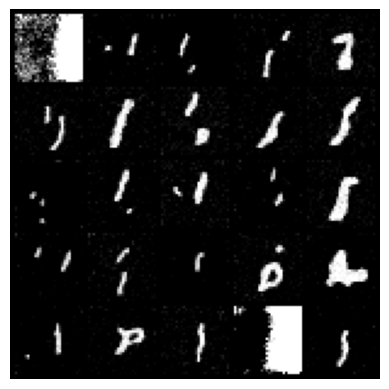

In [20]:
import matplotlib.pyplot as plt
plt.imshow(imgs[99])
plt.axis('off')
plt.show()